# Example of Filtering Embedded Pairs

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# System imports
import os
import sys
import yaml

# External imports
import matplotlib.pyplot as plt
import scipy as sp
from sklearn.decomposition import PCA
from sklearn.metrics import auc
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from pytorch_lightning.loggers import TensorBoardLogger, WandbLogger
from pytorch_lightning import Trainer

sys.path.append('..')
device = "cuda" if torch.cuda.is_available() else "cpu"

from LightningModules.Filter.Models.vanilla_filter import VanillaFilter
from LightningModules.Filter.Models.pyramid_filter import PyramidFilter

## Pytorch Lightning Model

### Construct PyLightning model

An ML model typically has many knobs to turn, as well as locations of data, some training preferences, and so on. For convenience, let's put all of these parameters into a YAML file and load it.

In [3]:
with open("example_filter.yaml") as f:
        hparams = yaml.load(f, Loader=yaml.FullLoader)

We plug these parameters into a constructor of the `LayerlessEmbedding` Lightning Module. This doesn't **do** anything yet - merely creates the object.

In [4]:
model = PyramidFilter(hparams)

## The Dataset

In [7]:
model.setup(stage="fit")

Loading data


### Visualise geometry

Just as a sanity check, let's look directly at the geometry of the data, as well as some distributions. This is just to make sure that, e.g. it's normalised in some reasonable way (that is, it doesn't vary from -1000 to +1000 or some large numbers, but that it is distributed close to +1 and -1 - this makes training much more effective!), and there aren't weird outliers (this also damages training!). 

In [13]:
trainset = model.trainset

In [16]:
example_data = trainset[0]
r, phi, z = example_data.x.T

In [17]:
x, y = r*np.cos(phi*np.pi)*1000, r*np.sin(phi*np.pi)*1000
z = z*1000

(Text(0.5, 1.0, 'Down-beampipe Spacepoint Distribution'),
 Text(0.5, 0, 'x direction (mm)'),
 Text(0, 0.5, 'y direction (mm)'))

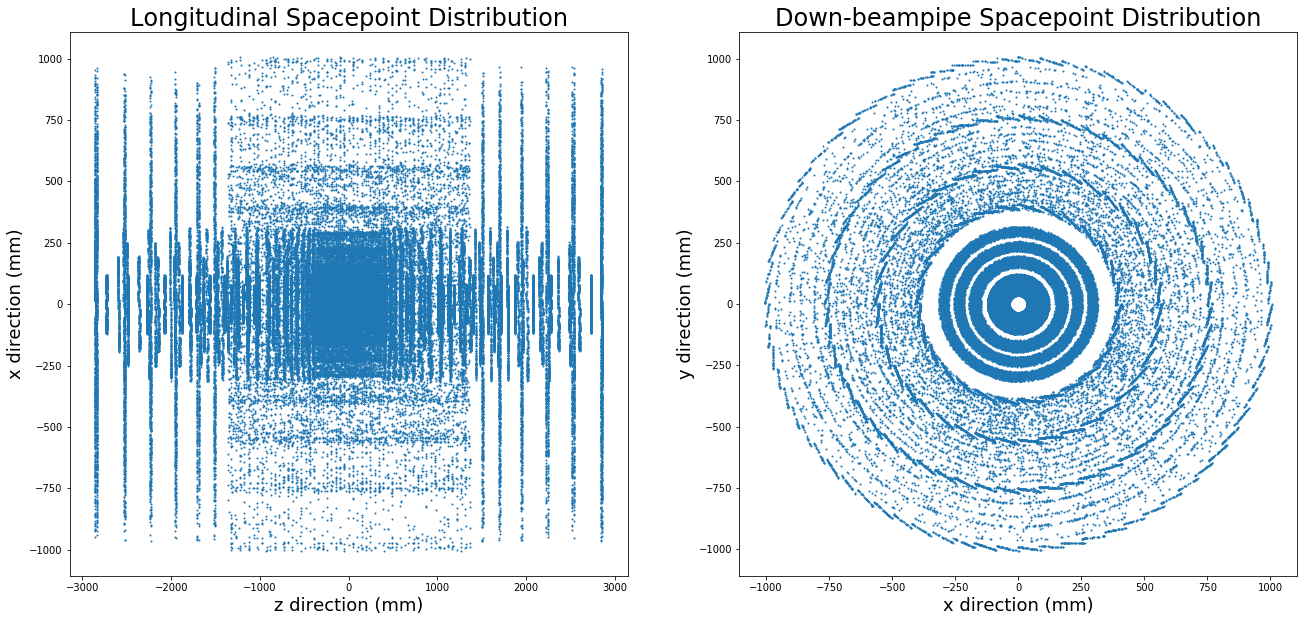

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(22,10))
axs[0].scatter(z, x, s=1)
axs[1].scatter(x, y, s=1)
axs[0].set_title("Longitudinal Spacepoint Distribution", fontsize=24), axs[0].set_xlabel("z direction (mm)", fontsize=18), axs[0].set_ylabel("x direction (mm)", fontsize=18)
axs[1].set_title("Down-beampipe Spacepoint Distribution", fontsize=24), axs[1].set_xlabel("x direction (mm)", fontsize=18), axs[1].set_ylabel("y direction (mm)", fontsize=18)

### Visualise distributions

(Text(0.5, 1.0, 'Distribution of Momentum'),
 Text(0.5, 0, 'pT (GeV)'),
 Text(0, 0.5, 'Count'))

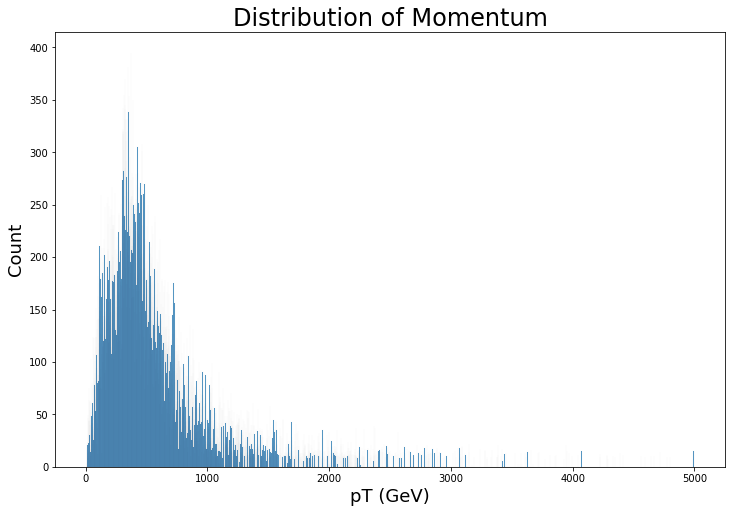

In [47]:
plt.figure(figsize=(12,8))
sns.histplot(example_data.pt[example_data.pt == example_data.pt], binwidth=200, binrange=[0, 5000])
plt.title("Distribution of Momentum", fontsize=24), plt.xlabel("pT (GeV)", fontsize=18), plt.ylabel("Count", fontsize=18)

(Text(0.5, 1.0, 'Distribution of Momentum'),
 Text(0.5, 0, 'pT (GeV)'),
 Text(0, 0.5, 'Count'))

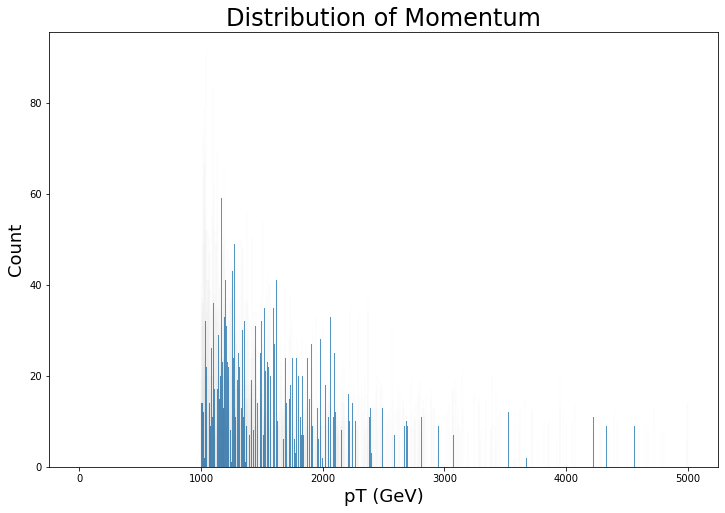

In [49]:
plt.figure(figsize=(12,8))
sns.histplot(example_data.pt[example_data.modulewise_true_edges[0]], binrange=[0, 5000])
plt.title("Distribution of Momentum", fontsize=24), plt.xlabel("pT (GeV)", fontsize=18), plt.ylabel("Count", fontsize=18)

Observe the hard cut-off below 1GeV - this is because we are ignoring lower energy hits to keep things easy for now. But we should include them again once we are happy with our ML architecture!

In [20]:
particle_num, particle_counts = np.unique(example_data.pid.numpy(), return_counts = True)

(Text(0.5, 1.0, 'Distribution of Hits per Particle'),
 Text(0.5, 0, 'Hits'),
 Text(0, 0.5, 'Count'))

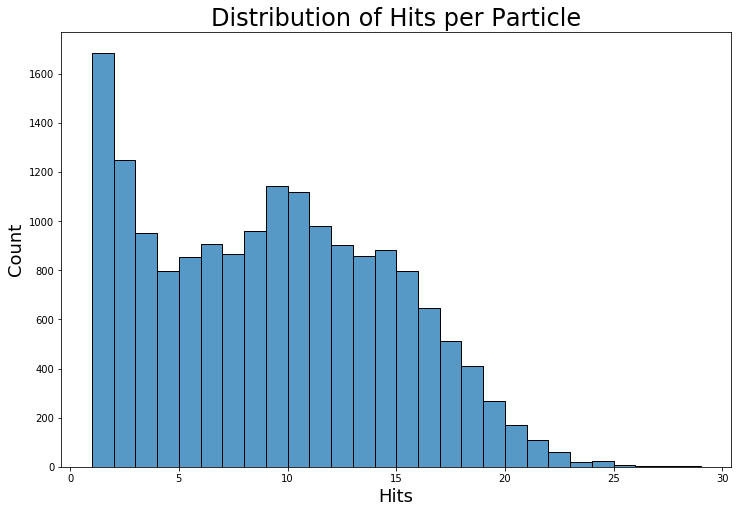

In [22]:
plt.figure(figsize=(12,8))
sns.histplot(particle_counts[:-1], binwidth=1)
plt.title("Distribution of Hits per Particle", fontsize=24), plt.xlabel("Hits", fontsize=18), plt.ylabel("Count", fontsize=18)

This gives an idea about how long each particle track is. We can see that most particle tracks leave > 10 hits, which will be useful for our graph neural networks down the track. In general, shorter tracks are harder to detect, and less useful for doing meaningful physics.

### Cell Info

In [20]:
cell_features = [
            "norm_x",
            "norm_y",
            "barrel_endcap",
            "layer_disk",
            "eta_module",
            "phi_module",
            "eta_angle_1",
            "phi_angle_1",
            "eta_angle_2",
            "phi_angle_2",
            "pixel"
        ]

In [21]:
example_data.cell_data

tensor([[ 0.3610,  0.1495,  0.0000,  ..., -1.0000, -1.0000,  1.0000],
        [ 0.0000,  0.0000, -2.0000,  ..., -1.0000, -1.0000,  1.0000],
        [ 0.0000,  0.0000,  2.0000,  ..., -1.0000, -1.0000,  1.0000],
        ...,
        [ 0.0000,  0.0000,  2.0000,  ...,  1.3239,  0.0059,  0.0000],
        [ 0.0000,  0.0000,  2.0000,  ...,  0.5373,  0.0064,  0.0000],
        [ 0.0000,  0.0000,  2.0000,  ...,  1.3246,  0.0064,  0.0000]])

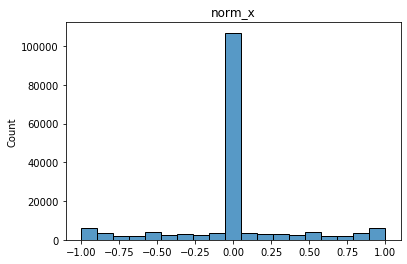

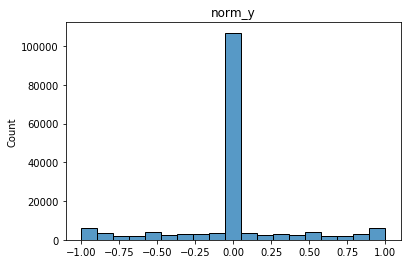

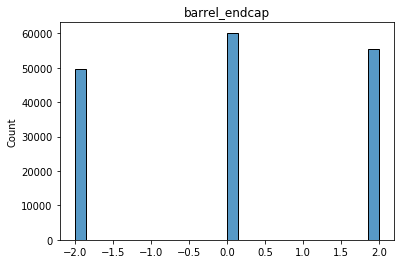

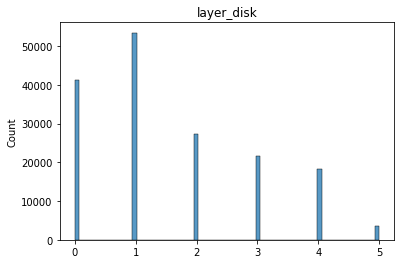

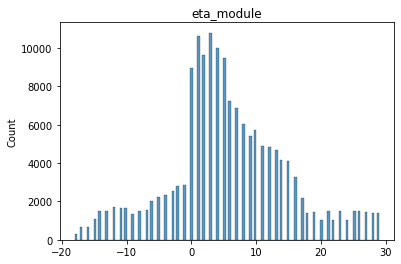

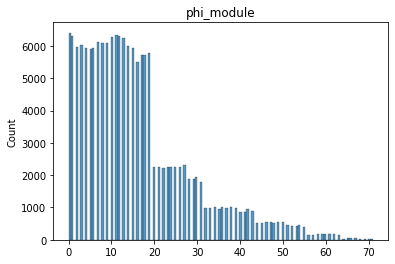

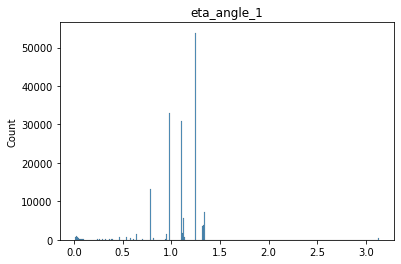

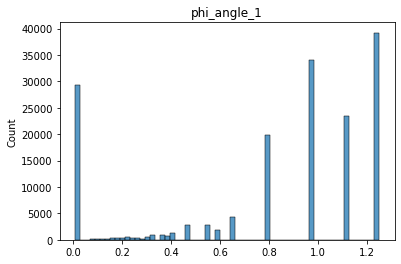

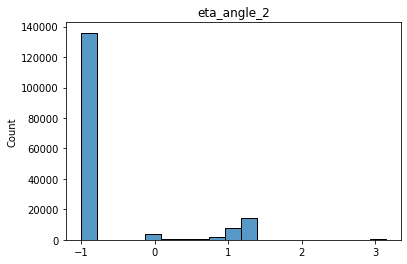

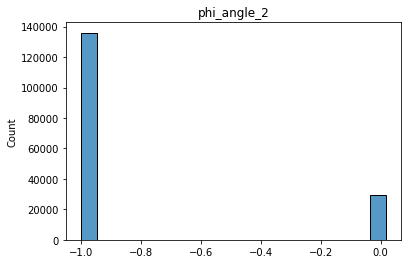

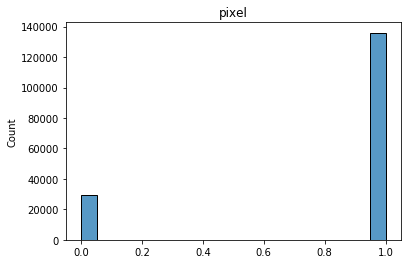

In [22]:
for i, feature in enumerate(cell_features):
    plt.figure()
    sns.histplot(example_data.cell_data[:, i].numpy()).set_title(feature)

## Metric Learning

### Train filter

Finally! Let's train! We instantiate a `Trainer` class that knows things like which hardware to work with, how long to train for, and a **bunch** of default options that we ignore here. Check out the Trainer class docs in Pytorch Lightning. Suffice it to say that it clears away much repetitive boilerplate in training code.

In [5]:
from pytorch_lightning.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(
    monitor='eff',
    mode="max",
    save_top_k=2,
    save_last=True)

In [6]:
%%time
# logger = WandbLogger(project="ITk_0GeV_Filter", group="InitialTest")
trainer = Trainer(gpus=1, max_epochs=20, num_sanity_val_steps=0, logger=None, callbacks=[checkpoint_callback])
trainer.fit(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


Loading data


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.

  | Name         | Type       | Params
--------------------------------------------
0 | input_layer  | Linear     | 11.8 K
1 | layers       | ModuleList | 164 K 
2 | output_layer | Linear     | 129   
3 | act          | Tanh       | 0     
--------------------------------------------
176 K     Trainable params
0         Non-trainable params
176 K     Total params
0.705     Total estimated model params size (MB)
/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/global/homes/d/danie

Training: 0it [00:00, ?it/s]

Device: cpu
Device: cpu
Device: cpu
Device: cpu
Device: cpu
Device: cpu
Device: cpu
Device: cpu
Retrieved batch
Running model
Running loss
Train done
Retrieved batch
Running model
Running loss
Train done
Retrieved batch
Running model
Running loss
Train done
Device: cpu
Device: cpu
Retrieved batch
Running model
Running loss
Train done
Retrieved batch
Running model
Running loss
Train done
Retrieved batch
Running model
Running loss
Train done
Retrieved batch
Running model
Running loss
Train done
Retrieved batch
Running model
Running loss
Train done
Retrieved batch
Running model
Running loss
Train done
Retrieved batch
Running model
Running loss
Train done


Validating: 0it [00:00, ?it/s]

/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Chunk 0
Chunk 1
Chunk 2
Chunk 3
Chunk 4
Chunk 5
Chunk 6
Chunk 7
Chunk 8
Chunk 9
Chunk 10
Chunk 11
Chunk 12
Chunk 13
Chunk 14
Chunk 15
Chunk 16
Chunk 17
Chunk 18
Chunk 19
Chunk 20
Chunk 21
Chunk 22
Chunk 23
Chunk 24
Chunk 25
Chunk 26
Chunk 27
Chunk 28
Chunk 29
Chunk 30
Chunk 31
Chunk 32
Chunk 33
Chunk 34
Chunk 35
Chunk 36
Chunk 37
Chunk 38
Chunk 39
Chunk 40
Chunk 41
Chunk 42
Chunk 43
Chunk 44
Chunk 45
Chunk 46
Chunk 47
Chunk 48
Chunk 49
Chunk 50
Chunk 51
Chunk 52
Chunk 53
Chunk 54
Chunk 55
Chunk 56
Chunk 57
Chunk 58
Chunk 59
Chunk 60
Chunk 61
Chunk 62
Chunk 63
Chunk 64
Chunk 65
Chunk 66
Chunk 67
Chunk 68
Chunk 69
Chunk 70
Chunk 71
Chunk 72
Chunk 73
Chunk 74
Chunk 75
Chunk 76
Chunk 77
Chunk 78
Chunk 79


../LightningModules/Filter/filter_base.py:230: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "eff": torch.tensor(edge_true_positive / edge_true.sum()),
../LightningModules/Filter/filter_base.py:231: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "pur": torch.tensor(edge_true_positive / edge_positive),


Chunk 0
Chunk 1
Chunk 2
Chunk 3
Chunk 4
Chunk 5
Chunk 6
Chunk 7
Chunk 8
Chunk 9
Chunk 10
Chunk 11
Chunk 12
Chunk 13
Chunk 14
Chunk 15
Chunk 16
Chunk 17
Chunk 18
Chunk 19
Chunk 20
Chunk 21
Chunk 22
Chunk 23
Chunk 24
Chunk 25
Chunk 26
Chunk 27
Chunk 28
Chunk 29
Chunk 30
Chunk 31
Chunk 32
Chunk 33
Chunk 34
Chunk 35
Chunk 36
Chunk 37
Chunk 38
Chunk 39
Chunk 40
Chunk 41
Chunk 42
Chunk 43
Chunk 44
Chunk 45
Chunk 46
Chunk 47
Chunk 48
Chunk 49
Chunk 50
Chunk 51
Chunk 52
Chunk 53
Chunk 54
Chunk 55
Chunk 56
Chunk 57
Chunk 58
Chunk 59
Chunk 60
Chunk 61
Chunk 62
Chunk 63
Chunk 64
Chunk 65
Chunk 66
Chunk 67
Chunk 68
Chunk 69
Chunk 70
Chunk 71
Chunk 72
Chunk 73
Chunk 74
Chunk 75
Chunk 76
Chunk 77
Chunk 78
Chunk 79
Device: cpu
Device: cpu
Device: cpu
Device: cpu
Device: cpu
Device: cpu
Device: cpu
Device: cpu
Retrieved batch
Running model
Running loss
Train done
Retrieved batch
Running model
Running loss
Train done
Retrieved batch
Running model
Running loss
Train done
Device: cpu
Device: cpu
Retrieve

Validating: 0it [00:00, ?it/s]

Chunk 0
Chunk 1
Chunk 2
Chunk 3
Chunk 4
Chunk 5
Chunk 6
Chunk 7
Chunk 8
Chunk 9
Chunk 10
Chunk 11
Chunk 12
Chunk 13
Chunk 14
Chunk 15
Chunk 16
Chunk 17
Chunk 18
Chunk 19
Chunk 20
Chunk 21
Chunk 22
Chunk 23
Chunk 24
Chunk 25
Chunk 26
Chunk 27
Chunk 28
Chunk 29
Chunk 30
Chunk 31
Chunk 32
Chunk 33
Chunk 34
Chunk 35
Chunk 36
Chunk 37
Chunk 38
Chunk 39
Chunk 40
Chunk 41
Chunk 42
Chunk 43
Chunk 44
Chunk 45
Chunk 46
Chunk 47
Chunk 48
Chunk 49
Chunk 50
Chunk 51
Chunk 52
Chunk 53
Chunk 54
Chunk 55
Chunk 56
Chunk 57
Chunk 58
Chunk 59
Chunk 60
Chunk 61
Chunk 62
Chunk 63
Chunk 64
Chunk 65
Chunk 66
Chunk 67
Chunk 68
Chunk 69
Chunk 70
Chunk 71
Chunk 72
Chunk 73
Chunk 74
Chunk 75
Chunk 76
Chunk 77
Chunk 78
Chunk 79
Chunk 0
Chunk 1
Chunk 2
Chunk 3
Chunk 4
Chunk 5
Chunk 6
Chunk 7
Chunk 8
Chunk 9
Chunk 10
Chunk 11
Chunk 12
Chunk 13
Chunk 14
Chunk 15
Chunk 16
Chunk 17
Chunk 18
Chunk 19
Chunk 20
Chunk 21
Chunk 22
Chunk 23
Chunk 24
Chunk 25
Chunk 26
Chunk 27
Chunk 28
Chunk 29
Chunk 30
Chunk 31
Chunk 32
Chu

Validating: 0it [00:00, ?it/s]

/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:897: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn('Detected KeyboardInterrupt, attempting graceful shutdown...')


CPU times: user 1min 10s, sys: 2min 22s, total: 3min 32s
Wall time: 3min 37s
Error in callback <bound method AutoreloadMagics.post_execute_hook of <autoreload.AutoreloadMagics object at 0x2aaab4871050>> (for post_execute):


KeyboardInterrupt: 

### Test filter

A Pytorch Lightning Trainer has two main methods: `fit` and `test`. They represent the two main steps of any ML engingeering or research: Train a model, then make sure it can infer accurately on test (i.e. **hidden**) data.

Note that `ckpt_path` just tells the trainer to use the latest "checkpoint" of the model, rather than *best* checkpoint. A checkpoint is a saved version of the model, a snapshot at a particular stage of the training process. Pytorch Lightning automatically saves a checkpoint of your model in case something crashes and we need to resume.

In [23]:
test_results = trainer.test(ckpt_path=None)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'current_lr': 0.0005999999702908099,
 'eff': 0.9709646701812744,
 'pur': 0.055771585553884506,
 'val_loss': 0.9984596371650696}
--------------------------------------------------------------------------------


## Performance

In [3]:
checkpoint_path = "/global/cscratch1/sd/danieltm/ExaTrkX/itk_lightning_checkpoints/ITk_1GeV_Filter/avcwv9al/checkpoints/last.ckpt"
checkpoint = torch.load(checkpoint_path)

model = PyramidFilter.load_from_checkpoint(checkpoint_path).to(device)

In [4]:
model.eval();

In [5]:
model.hparams["datatype_split"] = [10, 1, 10]
# model.setup(stage="fit")

In [6]:
batch = model.testset[1]

In [7]:
with torch.no_grad():
    test_results = model.test_step(model.testset[1].to(device), 0)

/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [8]:
cut = 0.2

In [11]:
test_results["preds"].shape

torch.Size([1758556])

In [13]:
(test_results["preds"] > cut).sum()

tensor(958606, device='cuda:0')

In [14]:
(test_results["trues"] & (test_results["preds"] > cut)).sum()

tensor(11892, device='cuda:0')

In [102]:
(test_results["trues"] & (test_results["preds"] > cut)).sum() / (test_results["preds"] > cut).sum()

tensor(0.0124, device='cuda:0')

In [103]:
(test_results["trues"] & (test_results["preds"] > cut)).sum() / test_results["trues"].int().sum()

tensor(0.9881, device='cuda:0')

In [9]:
test_results

{'preds': tensor([0.0146, 0.0146, 0.0145,  ..., 0.0043, 0.0042, 0.0042], device='cuda:0'),
 'trues': tensor([False, False, False,  ..., False, False, False], device='cuda:0'),
 'loss': tensor(3.7315, device='cuda:0')}

In [82]:
subset_mask = np.isin(batch.edge_index.cpu(), batch.modulewise_true_edges.unique().cpu()).any(0)

In [59]:
test_results["preds"].cpu()[::100].shape

torch.Size([17586])

In [77]:
true_preds.shape

torch.Size([12035])

In [78]:
false_preds.shape

torch.Size([1746521])

In [87]:
true_preds = test_results["preds"][test_results["trues"].cpu() & subset_mask]
false_preds = test_results["preds"][~test_results["trues"].cpu() & subset_mask]

/global/homes/d/danieltm/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
  """Entry point for launching an IPython kernel.
/global/homes/d/danieltm/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
  


## Build Edges

In [12]:

import copy
class FilterInferenceBuilder:
    def __init__(self, model, output_dir, overwrite=False):
        self.output_dir = output_dir
        self.model = model
        self.overwrite = overwrite

        # Prep the directory to produce inference data to
        self.datatypes = ["train", "val", "test"]
        os.makedirs(self.output_dir, exist_ok=True)
        [
            os.makedirs(os.path.join(self.output_dir, datatype), exist_ok=True)
            for datatype in self.datatypes
        ]
        
        # Get [train, val, test] lists of files
        self.dataset_list = []
        for dataname in model.hparams["datatype_names"]:
            dataset = os.listdir(os.path.join(model.hparams["input_dir"], dataname))
            dataset = sorted([os.path.join(model.hparams["input_dir"], dataname, event) for event in dataset])
            self.dataset_list.append(dataset)
        

    def build(self):
        print("Training finished, running inference to build graphs...")

        # By default, the set of examples propagated through the pipeline will be train+val+test set
        datasets = {
            "train": self.dataset_list[0],
            "val": self.dataset_list[1],
            "test": self.dataset_list[2],
        }
        total_length = sum([len(dataset) for dataset in datasets.values()])
        batch_incr = 0
        self.model.eval()
        with torch.no_grad():
            for set_idx, (datatype, dataset) in enumerate(datasets.items()):
                for event_idx, event_file in enumerate(dataset):
                    percent = (batch_incr / total_length) * 100
                    sys.stdout.flush()
                    sys.stdout.write(f"{percent:.01f}% inference complete \r")
                    batch = torch.load(event_file).to(device)
                    if (
                        not os.path.exists(
                            os.path.join(
                                self.output_dir, datatype, batch.event_file[-4:]
                            )
                        )
                    ) or self.overwrite:
                        batch_to_save = copy.deepcopy(batch)
                        batch_to_save = batch_to_save.to(
                            self.model.device
                        )  # Is this step necessary??
                        self.construct_downstream(batch_to_save, datatype)

                    batch_incr += 1

    def construct_downstream(self, batch, datatype):

        
        emb = (
            None if (self.model.hparams["emb_channels"] == 0) else batch.embedding
        )  # Does this work??

        cut_list = []
        for j in range(self.model.hparams["n_chunks"]):
            subset_ind = torch.chunk(torch.arange(batch.edge_index.shape[1]), self.model.hparams["n_chunks"])[
                j
            ]
            output = (
                self.model(
                    torch.cat([batch.cell_data[:, :self.model.hparams["cell_channels"]], batch.x], axis=-1),
                    batch.edge_index[:, subset_ind],
                    emb,
                ).squeeze()
                if ("ci" in self.model.hparams["regime"])
                else self.model(batch.x, batch.edge_index[:, subset_ind], emb).squeeze()
            )
            cut = torch.sigmoid(output) > self.model.hparams["filter_cut"]
            cut_list.append(cut)

        cut_list = torch.cat(cut_list)

        if "pid" not in self.model.hparams["regime"]:
            batch.y = batch.y[cut_list]

            print(batch.y.shape)
            print(batch.y.sum())
            
        y_pid = batch.pid[batch.edge_index[0]] == batch.pid[batch.edge_index[1]]
        batch.y_pid = y_pid[cut_list]
        batch.edge_index = batch.edge_index[:, cut_list]
        if "weighting" in self.model.hparams["regime"]:
            batch.weights = batch.weights[cut_list]

        self.save_downstream(batch, datatype)
        
        

    def save_downstream(self, batch, datatype):

        with open(
            os.path.join(self.output_dir, datatype, batch.event_file[-4:]), "wb"
        ) as pickle_file:
            torch.save(batch, pickle_file)

In [14]:
output_dir = "/project/projectdirs/m3443/data/ITk-upgrade/processed/filter_processed/1_GeV_unweighted_high_eff"
model.hparams["train_split"] = [10, 1, 1]
model.hparams["filter_cut"] = 0.15

In [ ]:
edge_builder = FilterInferenceBuilder(model, output_dir, overwrite=True)
    
edge_builder.build()

Training finished, running inference to build graphs...
torch.Size([732541])ete 
tensor(3610, device='cuda:0')
torch.Size([757733])ete 
tensor(3275, device='cuda:0')
torch.Size([400687])ete 
tensor(2412, device='cuda:0')
torch.Size([505722])ete 
tensor(2447, device='cuda:0')
torch.Size([813216])ete 
tensor(3576, device='cuda:0')
torch.Size([830793])ete 
tensor(3759, device='cuda:0')
torch.Size([519213])ete 
tensor(2514, device='cuda:0')
torch.Size([726540])ete 
tensor(3431, device='cuda:0')
torch.Size([880201])ete 
tensor(3885, device='cuda:0')
torch.Size([748403])ete 
tensor(3545, device='cuda:0')
torch.Size([736408])ete 
tensor(3227, device='cuda:0')
torch.Size([681831])ete 
tensor(3000, device='cuda:0')
torch.Size([600417])ete 
tensor(3093, device='cuda:0')
torch.Size([887521])ete 
tensor(3707, device='cuda:0')
torch.Size([655031])ete 
tensor(3476, device='cuda:0')
torch.Size([841009])ete 
tensor(3751, device='cuda:0')
torch.Size([677400])ete 
tensor(3179, device='cuda:0')
torch.Siz

## Debug Dataloader

In [16]:
from torch.utils.data import Dataset, DataLoader

In [5]:
from LightningModules.Filter.utils import load_dataset

In [107]:
class filter_dataset(Dataset):
    
    def __init__(self, dataset, hparams):
        
        # Setup here
        self.dataset = dataset
        self.hparams = hparams
        
    def __len__(self):
        
        return len(self.dataset)
    
    def __getitem__(self, idx):
        
        batch = self.dataset[idx]
        print(batch)
        
        print(batch.edge_index.device)
        
        if "subset" in self.hparams["regime"]:
            subset_mask = np.isin(batch.edge_index, batch.modulewise_true_edges.unique()).any(0)
            batch.edge_index = batch.edge_index[:, subset_mask]
            batch.y = batch.y[subset_mask]
            
        if self.hparams["ratio"] != 0:
            num_true, num_false = batch.y.bool().sum(), (~batch.y.bool()).sum()
            
            fake_indices = torch.where(~batch.y.bool())[0]
            
            fake_indices = fake_indices[torch.randint(len(fake_indices), (num_true.item() * self.hparams["ratio"], ))]

            true_indices = torch.where(batch.y.bool())[0]
            combined_indices = torch.cat([true_indices, fake_indices])
            
            # Shuffle indices:
            combined_indices = combined_indices[torch.randperm(len(combined_indices))]
            
        else:
            combined_indices = torch.range(batch.edge_index.shape[1])
        
        return {"x": batch.x, "cell_data": batch.cell_data, "edge_index": batch.edge_index[:, combined_indices], "y": batch.y[combined_indices]}

In [52]:
input_dirs = [None, None, None]
input_dirs[: len(hparams["datatype_names"])] = [
            os.path.join(hparams["input_dir"], datatype)
            for datatype in hparams["datatype_names"]
        ]
trainset, valset, testset = [
            load_dataset(input_dir, hparams["datatype_split"][i])
            for i, input_dir in enumerate(input_dirs)
        ]

In [108]:
train_dataset = filter_dataset(trainset, hparams)

In [109]:
trainloader = DataLoader(train_dataset)

In [110]:
%%time
for batch in trainloader:
    print(batch["edge_index"])
    break

Data(cell_data=[341982, 11], edge_index=[2, 101003780], event_file="/project/projectdirs/m3443/data/ITk-upgrade/processed/full_events_v4/event000000001", hid=[341982], modulewise_true_edges=[2, 105926], nhits=[341982], pid=[341982], primary=[341982], pt=[341982], x=[341982, 3], y=[101003780])
cpu
tensor([[[273383, 249188, 112490,  ..., 100450,   7873,  25971],
         [ 72816, 249189, 147802,  ..., 101111,   7948,  25927]]])
CPU times: user 1.57 s, sys: 1.39 s, total: 2.96 s
Wall time: 2.05 s


In [111]:
%%time
for batch in trainloader:
    print(batch["edge_index"])
    break

Data(cell_data=[341982, 11], edge_index=[2, 101003780], event_file="/project/projectdirs/m3443/data/ITk-upgrade/processed/full_events_v4/event000000001", hid=[341982], modulewise_true_edges=[2, 105926], nhits=[341982], pid=[341982], primary=[341982], pt=[341982], x=[341982, 3], y=[101003780])
cpu
tensor([[[158985, 179864, 105714,  ..., 133918,  86909,   7970],
         [138949, 210452,  96479,  ..., 134260,  79507,   7905]]])
CPU times: user 1.53 s, sys: 1.34 s, total: 2.86 s
Wall time: 2.03 s


In [80]:
%%time
print(train_dataset[1])

Data(cell_data=[273411, 11], edge_index=[2, 67594267], event_file="/project/projectdirs/m3443/data/ITk-upgrade/processed/full_events_v4/event000010002", hid=[273411], modulewise_true_edges=[2, 84055], nhits=[273411], pid=[273411], primary=[273411], pt=[273411], x=[273411, 3], y=[67594267])
cpu
ratio
1
2
shuffle
{'x': tensor([[ 0.0459, -0.8398, -0.2630],
        [ 0.0380, -0.9124, -0.2630],
        [ 0.0398, -0.8858, -0.2630],
        ...,
        [ 0.8879, -0.0572,  2.8542],
        [ 0.9639, -0.0350,  2.8542],
        [ 0.9285, -0.0371,  2.8542]]), 'edge_index': tensor([[ 91043,  88616,  24671,  ..., 201452, 261179,  56599],
        [ 84328, 112683,  24734,  ..., 200540, 266407,  56667]]), 'y': tensor([ True, False,  True,  ..., False, False,  True])}
CPU times: user 1.1 s, sys: 867 ms, total: 1.96 s
Wall time: 1.37 s


### Test metrics

In [27]:
all_efficiencies, all_purities = [], []
all_radius = np.arange(0.5, 1.2, 0.1)

with torch.no_grad():

    model.hparams.r_test = r
    test_results = trainer.test(ckpt_path=None)

    # Get eff, pur

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'current_lr': 0.0005999999702908099,
 'eff': 0.29412952065467834,
 'pur': 0.31158846616744995,
 'val_loss': 0.8040090799331665}
--------------------------------------------------------------------------------


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'current_lr': 0.0005999999702908099,
 'eff': 0.5026120543479919,
 'pur': 0.3214113712310791,
 'val_loss': 0.828713059425354}
--------------------------------------------------------------------------------


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'current_lr': 0.0005999999702908099,
 'eff': 0.6482229828834534,
 'pur': 0.2828279137611389,
 'val_loss': 0.8727149963378906}
--------------------------------------------------------------------------------


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'current_lr': 0.0005999999702908099,
 'eff': 0.745759904384613,
 'pur': 0.23499229550361633,
 'val_loss': 0.9117689728736877}
--------------------------------------------------------------------------------


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'current_lr': 0.0005999999702908099,
 'eff': 0.8200681805610657,
 'pur': 0.18902744352817535,
 'val_loss': 0.9429423809051514}
--------------------------------------------------------------------------------


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'current_lr': 0.0005999999702908099,
 'eff': 0.8717353343963623,
 'pur': 0.15006624162197113,
 'val_loss': 0.9644220471382141}
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'current_lr': 0.0005999999702908099,
 'eff': 0.9083821177482605,
 'pur': 0.12099817395210266,
 'val_loss': 0.9782997965812683}
--------------------------------------------------------------------------------


In [ ]:
eta_cuts = np.arange(-4, 4, 0.1)
pt_cuts = np.arange(1, 5, 0.5)

av_eta = test_results[""]
av_pt

for eta in eta_cuts

We should always visualise two important metrics: the efficiency (the number of true positives divided by the total number of possible true edges) and the purity (the number of true positives divided by the number of predicted edges). Is it clear to you why the graphs below behave as they do, as we widen the sphere around each hit to generate neighboring edges?

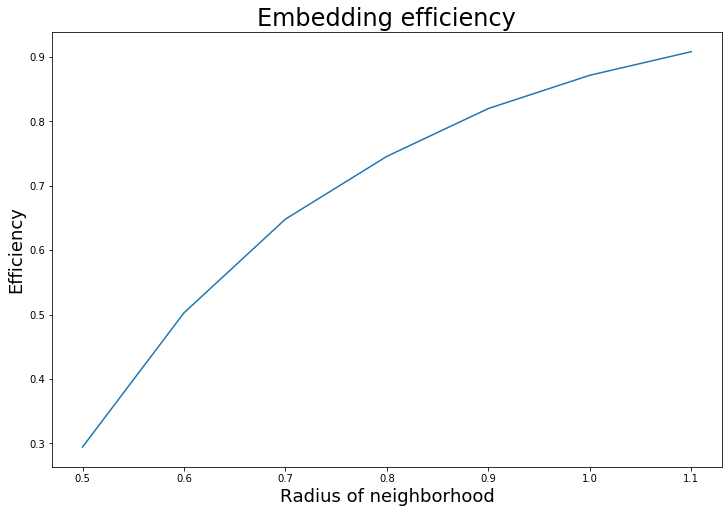

In [28]:
plt.figure(figsize=(12,8))
plt.plot(all_radius, all_efficiencies);
plt.title("Embedding efficiency", fontsize=24), plt.xlabel("Radius of neighborhood", fontsize=18), plt.ylabel("Efficiency", fontsize=18);

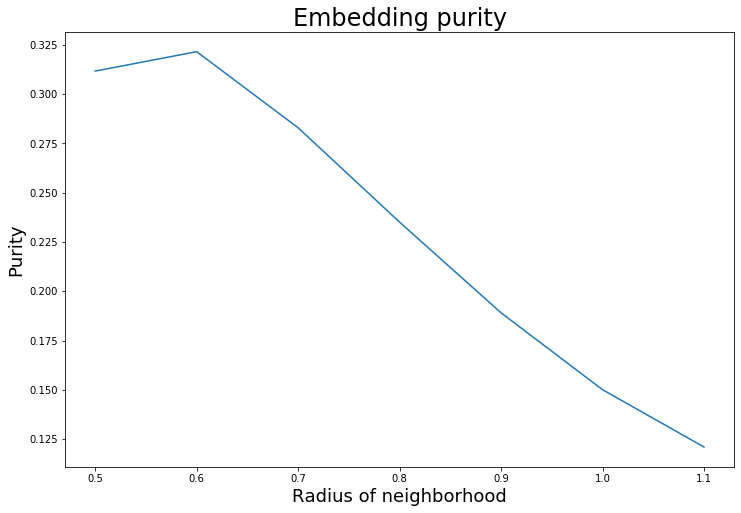

In [29]:
plt.figure(figsize=(12,8))
plt.plot(all_radius, all_purities);
plt.title("Embedding purity", fontsize=24), plt.xlabel("Radius of neighborhood", fontsize=18), plt.ylabel("Purity", fontsize=18);

### Visualise embedding / latent space

Another useful thing to visualise is the actual space being embedded into. Since it's 8 dimensional, we can reduce it to 2 dimensions with "Principal Component Analysis". 

In [24]:
from sklearn.decomposition import PCA

In [25]:
example_data = trainset[0]
particle_ids = example_data.pid
cyl_coords = example_data.x
cell_features = example_data.cell_data
all_features = torch.cat([cyl_coords, cell_features], axis=-1).to("cuda")

In [26]:
latent_features = model(all_features)

In [27]:
pca = PCA(n_components=2)

In [28]:
reduced_dimensions = pca.fit_transform(latent_features.detach().cpu())

In [29]:
reduced_dimensions

array([[-8.95513417, -3.68551328],
       [-9.26373197, -2.57803677],
       [17.49976278,  3.70361098],
       ...,
       [16.35837063, -5.6276739 ],
       [17.72111695, -4.57634675],
       [13.94139828, -8.52278351]])

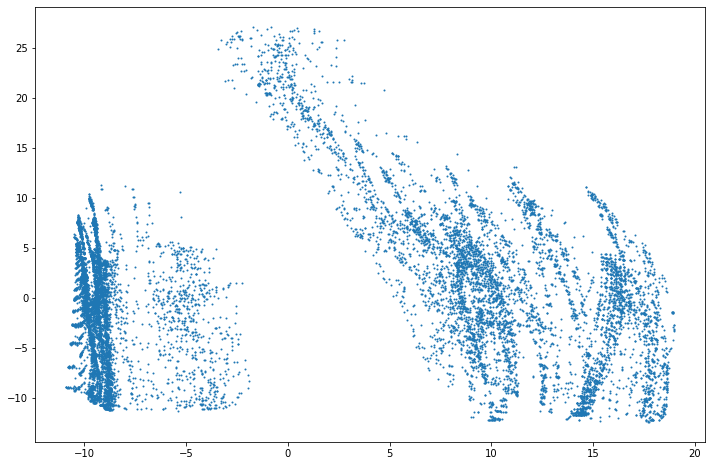

In [30]:
plt.figure(figsize=(12,8))
plt.scatter(reduced_dimensions[:, 0], reduced_dimensions[:, 1], s=1)

The above plot is what **all** the data looks like in the latent space. Let's pick a (long) particle track and see if the track is projected to be close together:

In [31]:
particles, counts = np.unique(example_data.pid, return_counts=True)

In [32]:
example_particle = particles[counts > 10][0]

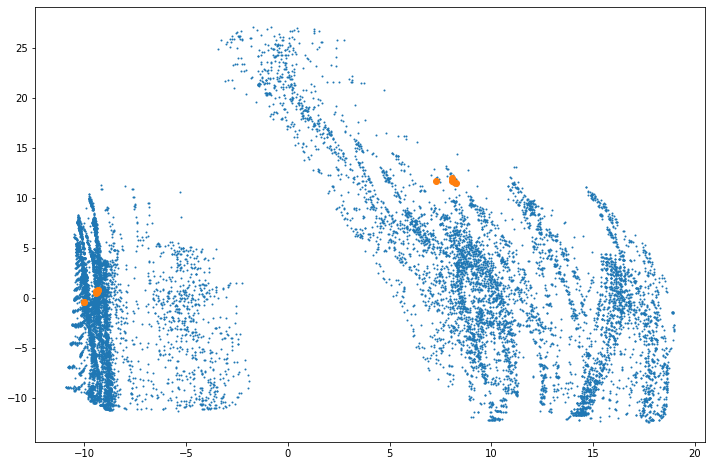

In [33]:
plt.figure(figsize=(12,8))
plt.scatter(reduced_dimensions[:, 0], reduced_dimensions[:, 1], s=1)
plt.scatter(reduced_dimensions[particle_ids == example_particle, 0], reduced_dimensions[particle_ids == example_particle, 1])

There are at least 10 hits in the plot above. Hopefully some of them cluster together into blobs, and that the blobs are close to other blobs of the same color. We get ~99% efficiency with this model, so even if some blobs appear far away in the PCA-reduced 2D space, they are most likely much closer in the 8-dimensional space. You can check this yourself!

## Further Investigation

1. Is there any performance gain from increasing the number of hidden channels?
2. What about *decreasing* the number of channels?
3. What about increasing/decreasing the number of dimensions in the latent space?
4. Is it possible to overtrain? That is, try increasing the number of epochs and seeing if the validation loss always decreases, plateaus, or starts to increase
5. Learning rate can be **everything** in some models. What effect does it have to increase/decrease it here?
6. Similarly, "warm-up" is like a slow start, where the learning rate increases for X batches (default of 100 here). Try changing it and seeing if you can improve the final performance.
7. To train the model here we use a combination of random pairs (that is, just picking pairs of hits at random, seeing if they belong to the same track, and 